In [6]:
!cd server/LeFusion_LIDC

In [8]:
import sys
import os

# Add the server directory to the Python path
sys.path.append(os.path.abspath('./server/LeFusion_LIDC'))

In [9]:
import numpy as np

from server.LeFusion_LIDC.get_dataset.get_dataset import get_inference_dataloader
from server.LeFusion_LIDC.paths import IN_SERVER_DATA_DIR, SERVER_ASSET_DATA_DIR


In [10]:
# Define dataloader
dl = get_inference_dataloader(
    dataset_root_dir=IN_SERVER_DATA_DIR,
    test_txt_dir=None,
    batch_size=1,
    slicer=True # NOTE defines whether the loaded data is from slicer or not
)
print("length of dataset:", len(dl))

length of dataset: 1


In [155]:
dl.dataset.preprocessing_img

Compose([Clamp(out_min=-1000, out_max=400), RescaleIntensity(out_min_max=(-1.0, 1.0), percentiles=(0, 100), masking_method=None), CropOrPad()])

In [99]:
from server.LeFusion_LIDC.paths import IN_SERVER_DATA_DIR
from server.LeFusion_LIDC.get_dataset.get_dataset import get_slicer_inference_dataloader

dl, train_dataset = get_slicer_inference_dataloader(
    dataset_root_dir=IN_SERVER_DATA_DIR, batch_size=1, return_dataset=True
)  
print("length of dataset:", len(dl))

length of dataset: 2


In [100]:
for sample in train_dataset:
    print(sample.keys())
    for key in sample.keys():
        print(key, np.shape(sample[key]))
    break

dict_keys(['GT', 'GT_name', 'gt_keep_mask', 'affine', 'histogram'])
GT (1, 32, 64, 64)
GT_name ()
gt_keep_mask torch.Size([1, 32, 64, 64])
affine (4, 4)
histogram ()


In [101]:
import torchio as tio
mask = tio.LabelMap(SERVER_ASSET_DATA_DIR / "LIDC-IDRI-0032_CMask_21.nii.gz")
mask.affine

array([[-1.25      ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.96289098,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.96289098,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [102]:
sample["gt_keep_mask"].shape

torch.Size([1, 32, 64, 64])

In [103]:
sample["histogram"]

array(1)

In [104]:
for batch in dl:
    print("batch:", batch.keys())
    for key in batch.keys():
        print(key, np.shape(batch[key]))
    break

batch: dict_keys(['GT', 'GT_name', 'gt_keep_mask', 'affine', 'histogram'])
GT torch.Size([1, 1, 32, 64, 64])
GT_name (1,)
gt_keep_mask torch.Size([1, 1, 32, 64, 64])
affine torch.Size([1, 4, 4])
histogram torch.Size([1])


In [106]:
batch['GT_name']

['/home/pedroosorio/pedr0sorio/lefusion-slicer/server/data/in/./img_data1.npz']

In [27]:
batch['affine'].squeeze(0)

tensor([[[ 1.2500,  0.0000,  0.0000],
         [ 0.0000, -0.9600,  0.0000],
         [ 0.0000,  0.0000, -0.9600]],

        [[ 1.2500,  0.0000,  0.0000],
         [ 0.0000, -0.9600,  0.0000],
         [ 0.0000,  0.0000, -0.9600]]], dtype=torch.float64)

In [9]:
batch["histogram"]

tensor([2])

In [10]:

gt_name = "LIDC-IDRI-0032_CMask_21.npz"
gt_name.rsplit('.npz', 1)

['LIDC-IDRI-0032_CMask_21', '']

In [62]:
from server.LeFusion_LIDC.paths import IN_SERVER_DATA_DIR, OUT_SERVER_DATA_DIR
def f():
    args = f"""
    python LeFusion_LIDC/test/inference.py
    dataset_root_dir={IN_SERVER_DATA_DIR.as_posix()}
    target_img_path={OUT_SERVER_DATA_DIR.as_posix()}
    schedule_jump_params.jump_length=2
    schedule_jump_params.jump_n_sample=2
    """.replace("    ", "").split("\n")
    args = [arg for arg in args if arg != ""]
    return args

In [63]:
f()

['python LeFusion_LIDC/test/inference.py',
 'dataset_root_dir=/home/pedroosorio/pedr0sorio/lefusion-slicer/server/data/in',
 'target_img_path=/home/pedroosorio/pedr0sorio/lefusion-slicer/server/data/out',
 'schedule_jump_params.jump_length=2',
 'schedule_jump_params.jump_n_sample=2']

In [69]:
import os
os.path.expanduser("LeFusion_LIDC/test/inference.py")

'LeFusion_LIDC/test/inference.py'

In [13]:
in_path = "/home/pedroosorio/pedr0sorio/lefusion-slicer/server/data/in/img_data0.npz"
npz_data = np.load(in_path, 'r', allow_pickle=True)
print(
    npz_data["data"].shape,
    npz_data["histogram"],
)
og_crop_scan = npz_data["data"]


(32, 64, 64) 3


(32, 64, 64) (1, 32, 64, 64) (1, 16)
['data_inpainted', 'mask', 'histogram', 'boxes_numpy']


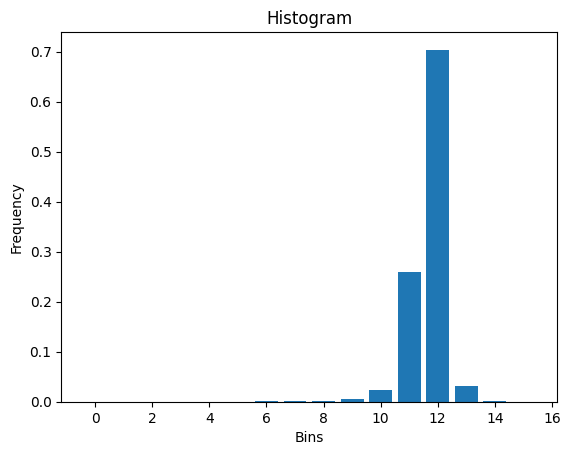

In [22]:
out_path = "/home/pedroosorio/pedr0sorio/lefusion-slicer/server/data/out/img_data0.npz"
npz_data = np.load(out_path, 'r', allow_pickle=True)
print(
    npz_data["data_inpainted"].shape,
    npz_data["mask"].shape,
    npz_data["histogram"].shape,
)
print(npz_data.files)

import matplotlib.pyplot as plt

plt.bar(range(npz_data["histogram"].shape[-1]), npz_data["histogram"].squeeze())
plt.title("Histogram")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.show()

inp_crop_scan = npz_data["data_inpainted"]
inp_mask = npz_data["mask"]


In [15]:
npz_data["histogram"].shape[-1]

16

In [16]:
import matplotlib.pyplot as plt
import torch

def plot_slices(image: torch.Tensor, interval: int = 10, direction: int = -1):
    """
    Plot every nth slice from a 3D image.

    Parameters:
    image (tio.ScalarImage): The 3D image to plot.
    interval (int): The interval between slices to plot. Default is 10.
    """
    # Extract the 3D tensor from the batch
    if image.ndim == 3:
        data = image
    elif image.ndim == 4:
        data = image[0]
    else:
        raise ValueError('Input image must be 3D or 4D.')

    num_slices = data.shape[direction]

    num_slices_show = num_slices // interval
    num_rows = int(np.ceil(np.sqrt(num_slices_show)))
    num_cols = int(np.ceil(num_slices_show / num_rows))
    # print(num_rows * num_cols, num_slices_show)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    for i in range(num_slices_show):
        ax = axes[i]
        if direction == 0:
            ax.imshow(data[i * interval, :, :], cmap='gray')
        elif direction == 1:
            ax.imshow(data[:, i * interval, :], cmap='gray')
        elif direction == 2 or direction == -1:
            ax.imshow(data[:, :, i * interval], cmap='gray')
        else:
            raise ValueError('Direction must be 0, 1, or 2.')
        ax.set_title(f'Slice {i * interval}')
        ax.axis('off')
    plt.show()


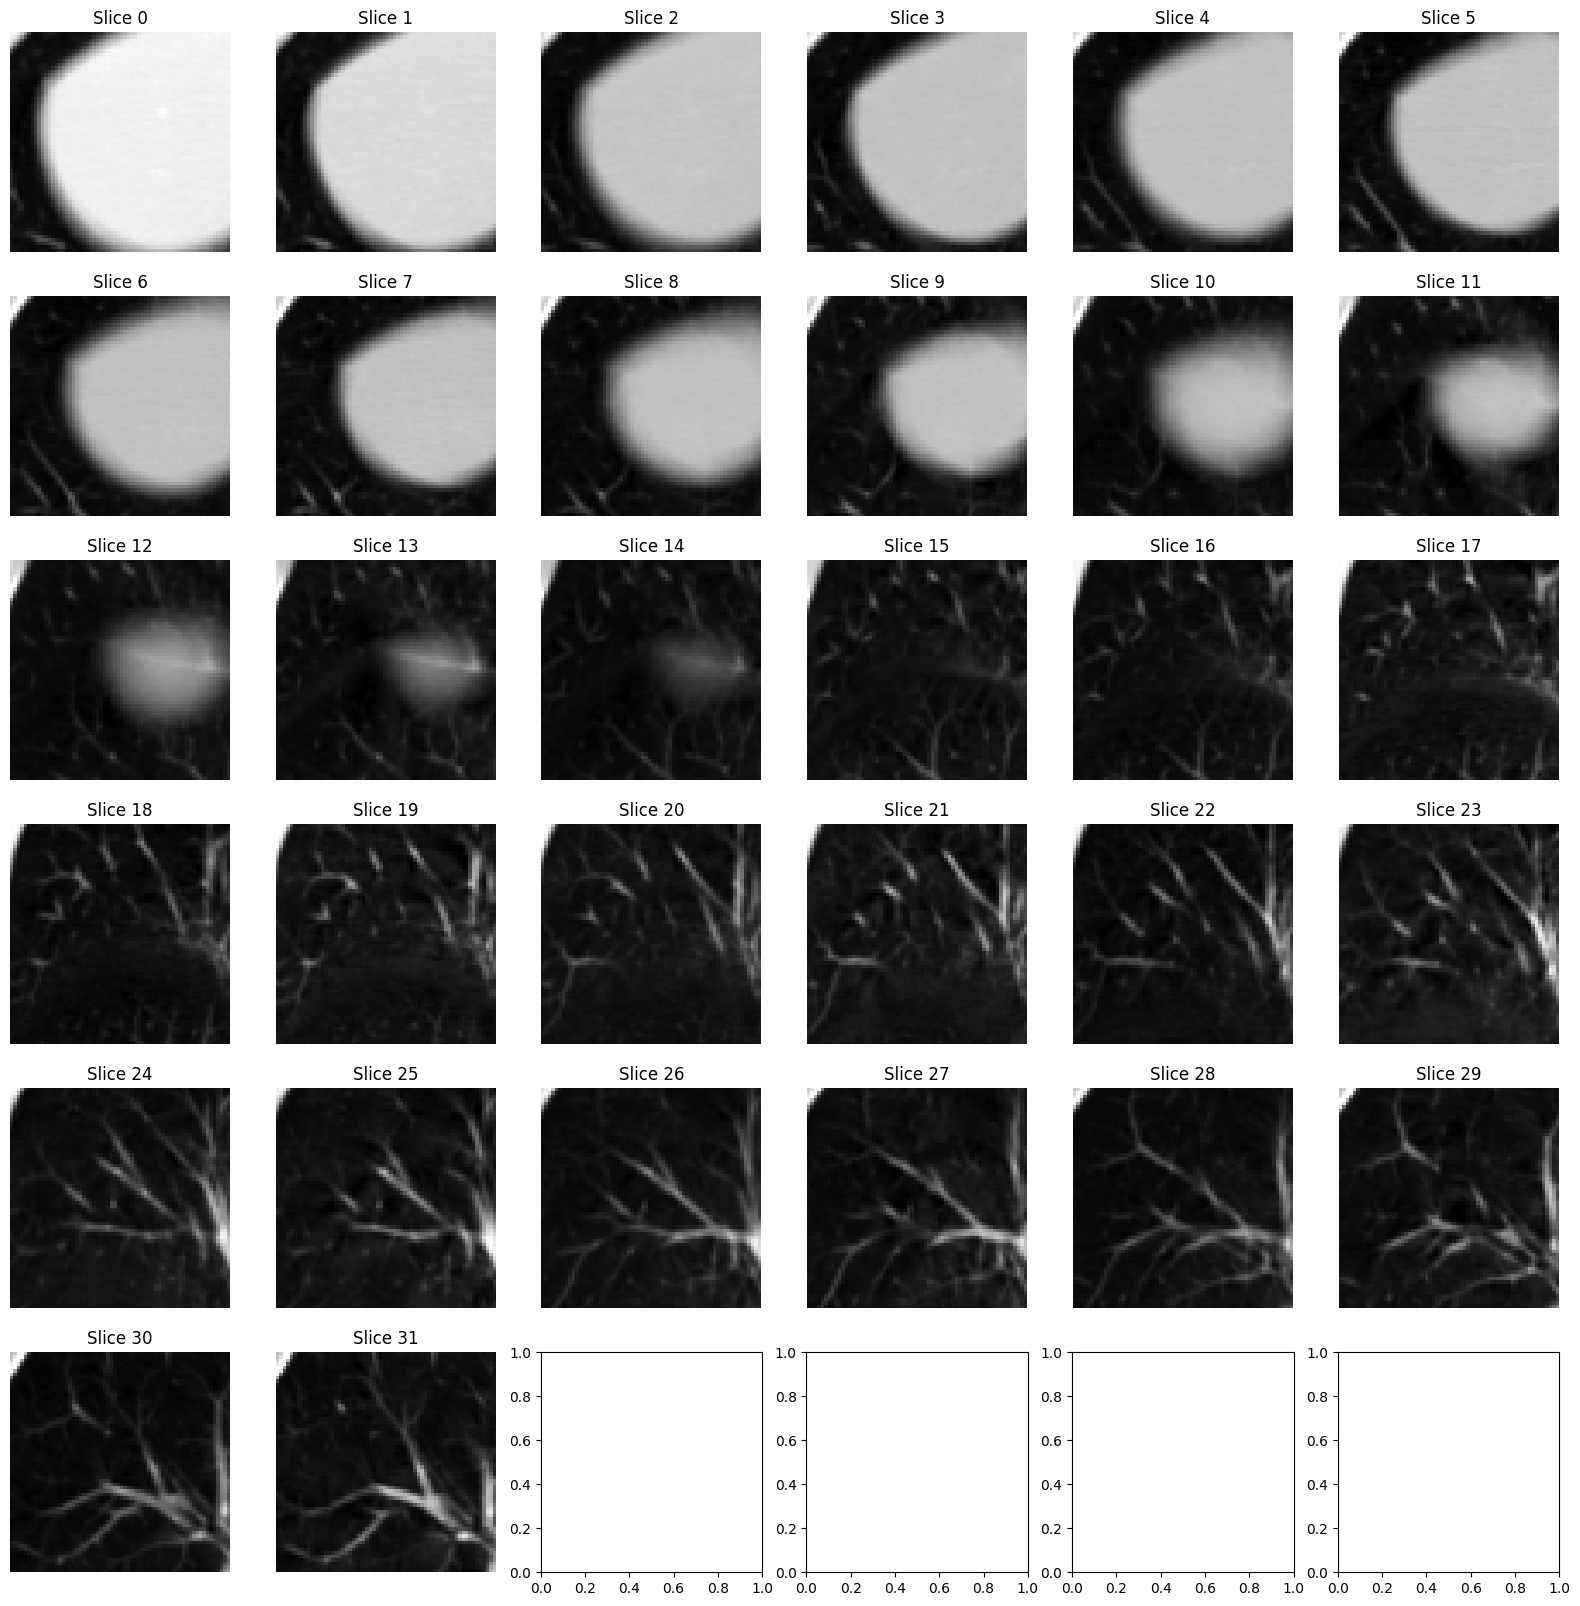

In [17]:
plot_slices(image = og_crop_scan, interval=1, direction=0)

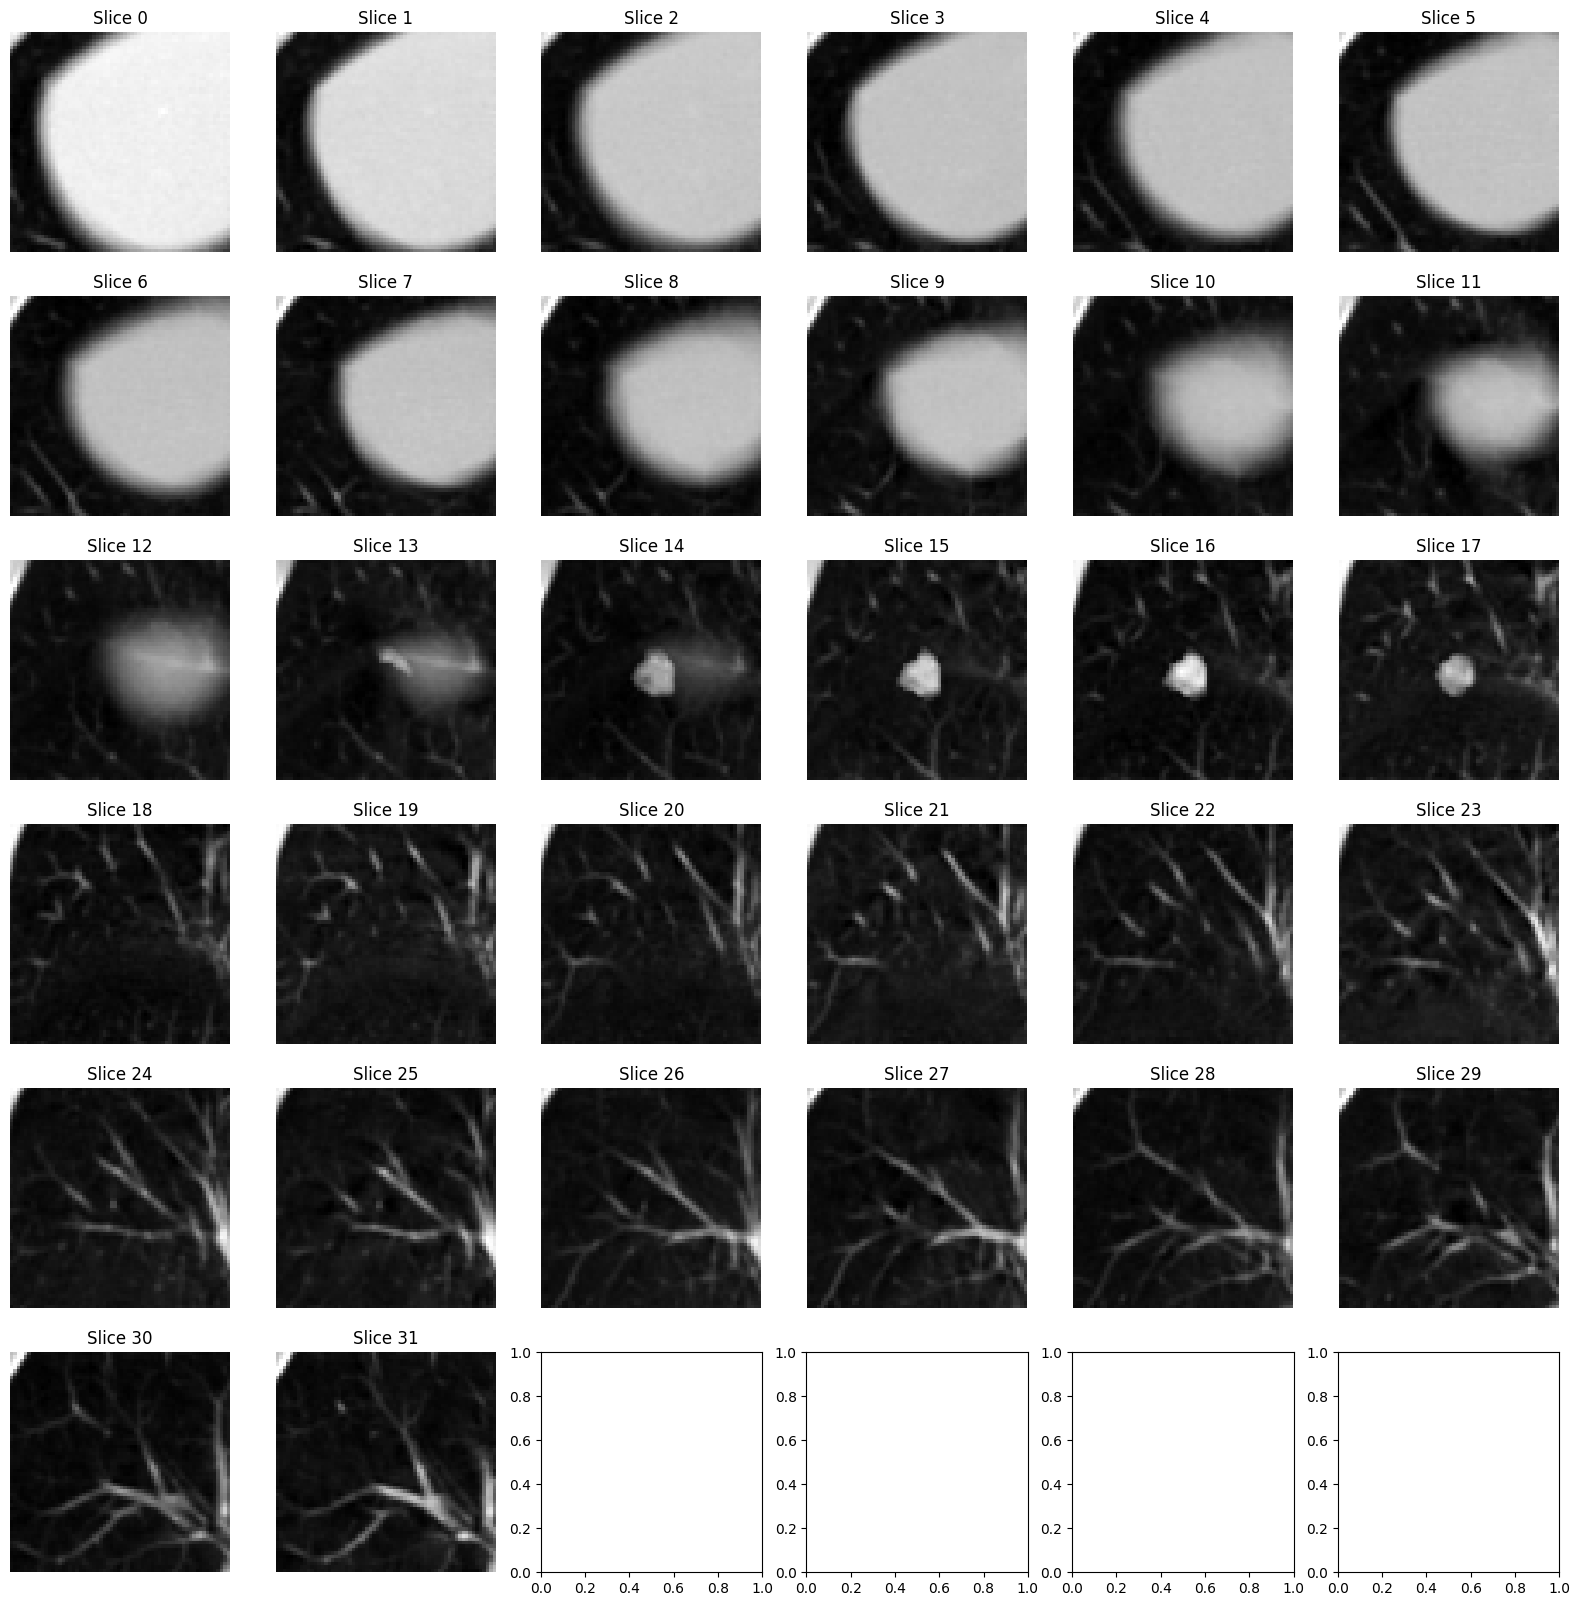

In [18]:
plot_slices(image = inp_crop_scan, interval=1, direction=0)

In [19]:
np.shape(inp_crop_scan)

(32, 64, 64)

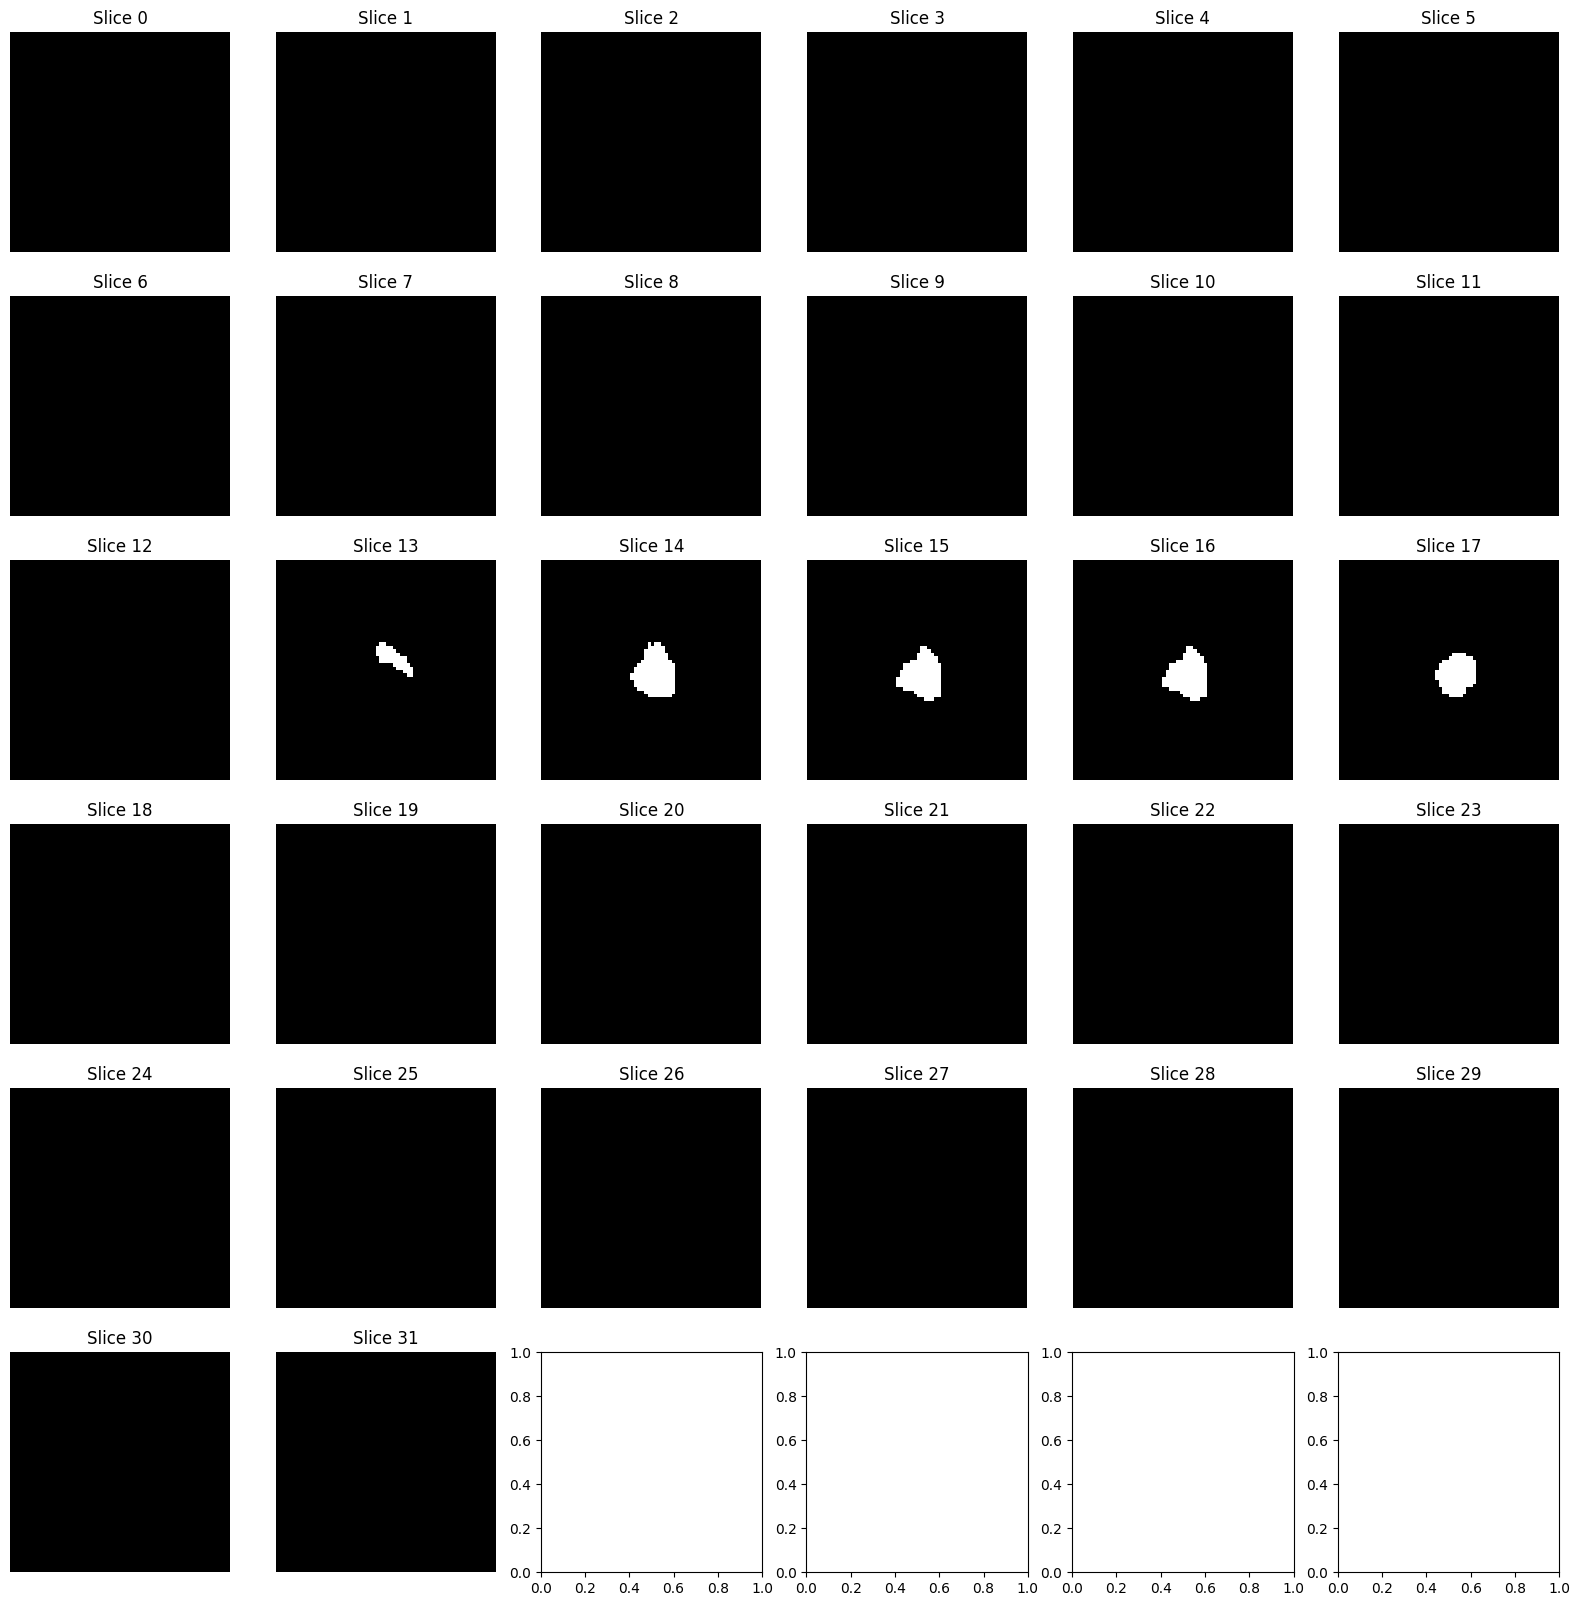

In [20]:
plot_slices(image = inp_mask, interval=1, direction=0)